In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
np.random.seed(0)

In [2]:
CAT_DIR = '../data/PetImages/Cat/'
DOG_DIR = '../data/PetImages/Dog/'

In [3]:
# Choose 10 images from each category randomly
cat_images = np.random.choice(os.listdir(CAT_DIR), 10)
dog_images = np.random.choice(os.listdir(DOG_DIR), 10)

In [4]:
# Choose 7 images from each category for training
train_cat_images = cat_images[:7]
train_dog_images = dog_images[:7]
test_cat_images = cat_images[7:]
test_dog_images = dog_images[7:]

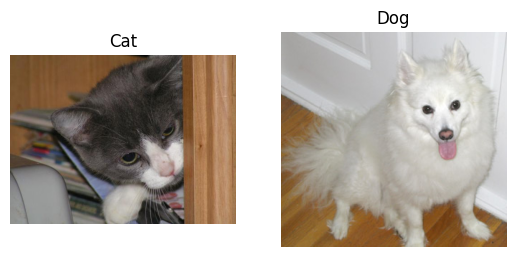

In [5]:
# Plot one cat image from train_cat_images and one dog image from train_dog_images
fig, axs = plt.subplots(1, 2)
cat_img = Image.open(CAT_DIR + train_cat_images[0])
dog_img = Image.open(DOG_DIR + train_dog_images[0])
axs[0].imshow(cat_img)
axs[0].set_title('Cat')
axs[0].axis('off')
axs[1].imshow(dog_img)
axs[1].set_title('Dog')
axs[1].axis('off')
plt.show()

### Cat: 0, Dog: 1

In [6]:
def get_data(dog_images, cat_images, resize_shape = (128, 128), shuffle = True):
    X = []
    y = []
    for dog_img in dog_images:
        img = Image.open(DOG_DIR + dog_img)
        img = img.resize(resize_shape)
        # Convert numbers to float and normalize them from 0 to 1
        img = np.array(img, dtype=np.float64) / 255.0
        # Take the average of the 3 color channels
        img = np.mean(img, axis=2)
        X.append(img)
        y.append(1)
    for cat_img in cat_images:
        img = Image.open(CAT_DIR + cat_img)
        img = img.resize(resize_shape)
        # Convert numbers to float and normalize them from 0 to 1
        img = np.array(img, dtype=np.float64) / 255.0
        # Take the average of the 3 color channels
        img = np.mean(img, axis=2)
        X.append(img)
        y.append(0)
    if shuffle:
        indices = np.random.permutation(len(X))
        X = [X[i] for i in indices]
        y = [y[i] for i in indices]
    return np.array(X), np.array(y)

In [7]:
resize_shape = (32, 32)
X_train, y_train = get_data(train_dog_images, train_cat_images, resize_shape = resize_shape)
X_test, y_test = get_data(test_dog_images, test_cat_images, resize_shape = resize_shape)

In [8]:
y_train

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0])

In [9]:
print(X_train.shape, y_train.shape)
X_train[0][:5, :5]

(14, 32, 32) (14,)


array([[0.65620915, 0.51372549, 0.49803922, 0.52156863, 0.58823529],
       [0.61568627, 0.51503268, 0.56470588, 0.63529412, 0.62745098],
       [0.67320261, 0.64052288, 0.65882353, 0.54771242, 0.5503268 ],
       [0.62352941, 0.67843137, 0.66405229, 0.58169935, 0.61437908],
       [0.58562092, 0.6248366 , 0.64313725, 0.55686275, 0.67973856]])

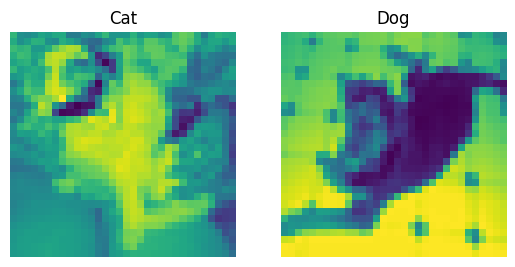

In [10]:
# Plot one cat image from train_cat_images and one dog image from train_dog_images
fig, axs = plt.subplots(1, 2)
# Pick a cat image
cat_img = X_train[y_train == 0][0]
# Pick a dog image
dog_img = X_train[y_train == 1][0]
axs[0].imshow(cat_img)
axs[0].set_title('Cat')
axs[0].axis('off')
axs[1].imshow(dog_img)
axs[1].set_title('Dog')
axs[1].axis('off')
plt.show()

In [11]:
class NN_Model:
    """
    NN_Model consists of a Conv layer followed by a dense layer
    """
    def __init__(self, input_shape = (64, 64), kernel_size = 4, strides = 2, padding = 0, 
                 num_filters = 4, dense_units = 1, lr = 0.01):
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.num_filters = num_filters
        self.dense_units = dense_units
        self.lr = lr
        self.conv_weights = np.random.randn(self.num_filters, self.kernel_size, self.kernel_size)
        self.conv_op_shape = (input_shape[0] + 2*padding - kernel_size) // strides + 1
        self.conv_op = np.zeros((num_filters, self.conv_op_shape, self.conv_op_shape))
        self.dense_w = np.random.randn(dense_units, num_filters * (self.conv_op_shape**2))
        self.dense_b = np.random.randn(dense_units, 1)

    def fit(self, X, y, num_epochs = 5, steps_per_epoch = 10, batch_size = 2,
            fr_change = 1.0e-4):
        for ep in range(num_epochs):
            for _ in tqdm(range(steps_per_epoch), desc=f'Epoch {str(ep+1)}'):
                # Pick a random batch of images
                idx = np.random.choice(X.shape[0], batch_size)
                X_batch = X[idx]
                y_batch = y[idx]

                # Pad all images with 0
                X_batch = np.pad(X_batch, ((0, 0), (self.padding, self.padding), (self.padding, self.padding)))

                comb_loss = 0.0

                for i in range(batch_size):
                    # Forward pass
                    A = self.forward(X_batch[i], self.conv_weights, self.dense_w, self.dense_b)
                    # Calculate loss
                    ls = self.loss_fn(y_batch[i], A)
                    comb_loss += ls

                for i in range(batch_size):
                    # Backward pass
                    self.backward(comb_loss, X_batch[i], y_batch[i], fr_change)
    
    def forward(self, X, conv_weights, dense_w, dense_b):
        self.conv_forward(X, conv_weights)
        # Flatten the conv_op
        conv_op_flat = self.conv_op.flatten().reshape(-1, 1)
        A = self.dense_forward(conv_op_flat, dense_w, dense_b)
        return A
    
    def loss_fn(self, y_true, y_pred):
        """
        Mean Squared Error loss function
        """
        ls = (y_true - y_pred)**2
        # Return the value from the array
        # Squeeze the array
        return ls.squeeze()
    
    def backward(self, loss, X, y, fr_change):
        # Change the value of each weight by 5% of its value
        # Calculate the loss
        # Gradient = (new_loss - old_loss) / (0.05*weight)

        self._temp_conv_weights = self.conv_weights.copy()
        self._temp_dense_w = self.dense_w.copy()
        self._temp_dense_b = self.dense_b.copy()

        # Iterate through conv_weights
        for f in range(self.num_filters):
            for i in range(self.kernel_size):
                for j in range(self.kernel_size):
                    self._temp_conv_weights[f, i, j] = (1.0+fr_change)*self.conv_weights[f, i, j]
                    A = self.forward(X, self._temp_conv_weights, self.dense_w, self.dense_b)
                    new_loss = self.loss_fn(y, A)
                    gradient = (new_loss - loss) / (fr_change*self.conv_weights[f, i, j])
                    self._temp_conv_weights[f, i, j] = self.conv_weights[f, i, j]
                    self.conv_weights[f, i, j] -= self.lr * gradient
        
        # Iterate through dense_w
        for i in range(self.dense_units):
            for j in range(self.dense_w.shape[1]):
                self._temp_dense_w[i, j] = (1.0 + fr_change)*self.dense_w[i, j]
                A = self.forward(X, self.conv_weights, self._temp_dense_w, self.dense_b)
                new_loss = self.loss_fn(y, A)
                gradient = (new_loss - loss) / (fr_change*self.dense_w[i, j])
                self._temp_dense_w[i, j] = self.dense_w[i, j]
                self.dense_w[i, j] -= self.lr * gradient
        
        # Iterate through dense_b
        for i in range(self.dense_units):
            self._temp_dense_b[i] = (1.0 + fr_change)*self.dense_b[i]
            A = self.forward(X, self.conv_weights, self.dense_w, self._temp_dense_b)
            new_loss = self.loss_fn(y, A)
            gradient = (new_loss - loss) / (fr_change*self.dense_b[i])
            self._temp_dense_b[i] = self.dense_b[i]
            self.dense_b[i] -= self.lr * gradient


    def conv_forward(self, X, conv_weights):
        # X is padded
        for f in range(self.num_filters):
            for i in range(self.conv_op_shape):
                for j in range(self.conv_op_shape):
                    i_start = i*self.strides
                    i_end = i_start + self.kernel_size
                    j_start = j*self.strides
                    j_end = j_start + self.kernel_size
                    temp_val = np.sum(X[i_start: i_end, j_start: j_end] * conv_weights[f])
                    # Apply ReLU
                    self.conv_op[f, i, j] = np.maximum(0, temp_val)

    def dense_forward(self, X, dense_w, dense_b):
        Z = np.dot(dense_w, X) + dense_b
        # Apply sigmoid
        A = 1 / (1 + np.exp(-Z))
        return A
    
    def predict(self, X):
        # X is an array of shape resize_shape
        # Pad X
        X_padded = np.pad(X, ((self.padding, self.padding), (self.padding, self.padding)))
        A = self.forward(X_padded, self.conv_weights, self.dense_w, self.dense_b)
        return A

In [12]:
model = NN_Model(input_shape = resize_shape,
                 kernel_size = 4,
                 strides = 2,
                 padding = 0,
                 num_filters = 4,
                 dense_units = 1,
                 lr = 0.01)

In [13]:
model.fit(X_train, y_train, num_epochs=2, batch_size=4, fr_change=1.0e-3)

Epoch 2: 100%|██████████| 10/10 [02:54<00:00, 17.46s/it]


In [14]:
# Find the accuracy on the test set
THR = 0.5
acc = 0.0
for i in range(X_test.shape[0]):
    pred = model.predict(X_test[i])
    print(f'Actual: {y_test[i]}, Predicted: {pred}')
    if pred > THR:
        pred = 1
    else:
        pred = 0
    if pred == y_test[i]:
        acc += 1.0
    # print(f'Actual: {y_test[i]}, Predicted: {pred}')
acc /= X_test.shape[0]
print(f'Accuracy: {acc*100.0}')

Actual: 1, Predicted: [[1.]]
Actual: 1, Predicted: [[1.]]
Actual: 1, Predicted: [[1.]]
Actual: 0, Predicted: [[1.]]
Actual: 0, Predicted: [[1.]]
Actual: 0, Predicted: [[1.]]
Accuracy: 50.0


In [15]:
# Store the model as a pickle file
import pickle
with open('../data/model.pkl', 'wb') as f:
    pickle.dump(model, f)